### ARMAX Models
Before jumping into Data-enabled Predictive Control (DeePC) we will introduce a dummy system in which we will be carrying out experiments. This system shall be an ARMAX process, this is a Linear Time Invariant system governed by the following transfer function.
$$A(z) y(t) = C(z) e(t) + B(z) u(t)$$

- $y$: System Output
- $e$: Non-deterministic Noise
- $u$: System Input
- $A(z) = 1 + a_1 z^{-1} + a_2 z^{-2} ... $ 
- $B(z) = b_0 + b_1 z^{-1} + b_2 z^{-2} ... $ 
- $C(z) = c_0 + c_1 z^{-1} + c_2 z^{-2} ... $ 

Leaving us the time difference equation:

$$ y(t) = -\left(a_1 y(t-1) + a_2 y(t-2) +... +a_{na} y(t-na)\right)+... \\
c_0 * e(t) + c_1 * e(t-1)+ ... +  c_{nc} * e(t-nc)+ ... \\  
b_0 * u(t) + b_1 * u(t-1)+ ... +  b_{nb} * u(t-nb)  $$ 

- $u \in R^m$
- $y \in R^p $

For simplicity in this example we will focus on SISO systems. 

In [118]:
# Install Packages needed for this example
using Pkg
# Pkg.add("Random")
# Pkg.add("LinearAlgebra")
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("JuMP")
# Pkg.add("Ipopt")
# Pkg.add("MultiObjectiveAlgorithms")
# Pkg.add("Statistics")
# Pkg.add("StatsPlots")
# Pkg.add("MathOptInterface")


   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [b8f27783] + MathOptInterface v1.16.0
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`



ARMAX: y(t) = (1-A(z)) y(t) + B(z)u(t) + C(z)e(t)
Coeffs of 1-A(z): [0.5, 0.25, 0.125]
Coeffs of B(z): [0.4]
Coeffs of C(z): [-0.21, -0.36, -0.013]


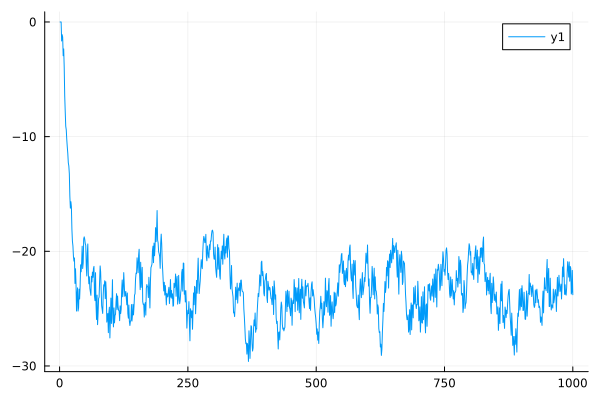

In [17]:
# ARMAX process generator
# A * y = C * e + B * u
# y - Output signal
# e - Random Noise
# u - Exogenous Input
using Random, LinearAlgebra, Plots

SimT=1000
na=3;nb=1;nc=3;
m=1;p=1;
# A_coeffs = rand(Float64,(na)).-0.5 # Coefficients of 1-A
# C_coeffs = (rand(Float64,(nc)).-0.5) # Coefficients of C
# B_coeffs = rand(Float64,(nb)).-0.5 # Coefficients of B
# A_coeffs = (1/2).^(1:na)

# This model presents nice curves  
A_coeffs = [0.5, 0.25, 0.125]
# B_coeffs = [0.3966450554650819]
# C_coeffs = [-0.20918333558208346, -0.3566816170797491, -0.013307061177314838]
B_coeffs = [0.40]
C_coeffs = [-0.21, -0.36, -0.013]


# t = range(1, SimT, length=SimT)
t=1:SimT
y = collect(t.*0.0) # Noise Generator
e = (rand(Float64, ( SimT)).-0.5).*10 .+ 5 # Noise Generator
# e = rand(Float64, ( SimT)) # Noise Generator
u = rand(Float64, ( SimT)).-0.5 # Noise Generator

# println(B_coeffs)
# println(y)
max_n = max(na,nb,nc)
println()
println("ARMAX: y(t) = (1-A(z)) y(t) + B(z)u(t) + C(z)e(t)")
println("Coeffs of 1-A(z): $(A_coeffs)")
println("Coeffs of B(z): $(B_coeffs)")
println("Coeffs of C(z): $(C_coeffs)")
for i in t
    y[i] = i>max_n ? dot(y[(i-na):(i-1)],A_coeffs) + dot(e[(i-nc+1):i],C_coeffs) + dot(u[(i-nb+1):i],B_coeffs) : 0
    
    # if i>max_n
    #      # println(dot(y[(i-na):(i-1)],A_coeffs))
    #     # println(dot(e[(i-nc+1):i],C_coeffs))
    #     # println((i-nb+1):i)
    #     # println(dot(u[(i-nb+1):i],B_coeffs))
    # end
end

# println(y)
# using Plots
plot(t,y)
# print(size(t))
# print(size(e))

# Can the stock price be modelled locally as an ARMAX model?


# DeePC

This section generically addresses the topic of Data Enabled Predictive Control (DeePC). Formulates are taken from:
> J. Coulson, J. Lygeros and F. Dörfler, "Data-Enabled Predictive Control: In the Shallows of the DeePC," 2019 18th European Control Conference (ECC), Naples, Italy, 2019, pp. 307-312, doi: 10.23919/ECC.2019.8795639.




### DeePC Algorithm
The algorithm below is presented for LTI systems with an unkown model, this is a system defined by the equation below where the matrices A, B, C, D are unknown.

$$
\left\{
    \begin{array}\\
        x(t+1)= A x(t) + B  u(t)) \\
        y(t)= C x(t) + D u(t)\\
        \end{array}
\right.
$$

The DeePC algorithm intends to solve the Optimal Control Problem below:

$$
\min_{g,u,y} 
    \sum_{k=0}^{N-1}\left(|y_k-r_{t+k}|_Q^2 + |u_k|_R^2\right)  \\
    s.t.\\
\begin{pmatrix} U_p \\ Y_p \\ U_f \\ Y_f \end{pmatrix} * g = \begin{pmatrix} u_{ini} \\ y_{ini} \\ u \\ y \end{pmatrix}
    $$

- $u$ and $y$ are not independent decision variables , they are defined by the matrices $U_f$ and  $Y_f$
- The decision variable is just $g$ because we can define u and y as follows
$$u=U_fg\\y=Y_fg$$

Then the problem becomes:

$$\min_g \sum_{k=0}^{N-1} \left(|\left(Y_fg\right)_k-r_{t+k}|_Q^2 +\left(U_fg\right)_k|_R^2    \right) $$
    
$$    s.t.\\
\begin{pmatrix} U_p \\ Y_p \end{pmatrix} * g = \begin{pmatrix} u_{ini} \\ y_{ini} \end{pmatrix}$$

##### Hankel Matrix
- $L$
- $T$ with $T \geq L $
$$H_L(u)= \begin{Bmatrix}
u_1 & \cdots & u_{T-L+1}\\
\vdots & \ddots & \vdots\\
u_L & \cdots & u_T
\end{Bmatrix}$$
- $H_L(u)$ needs to be full row rank for u to be persistently exiting of order L, meaning that all the rows of $H_L(u)$ need to be independent.

In [19]:

# Having the data let's say that the problem is to minimize 
# the absolute value of y and to small degree of u 


ts = 250 # Timestamp we pick
# T: Number of data points T>= (m+1)*(T_ini+N+n(B))-1, where n(B) is the smallest state dimension

# T-L+1: Number of block columns in Hankel matrix
# L : Number of block rows in the hankel matrix (Needs to be the same as block elements in u_ini) : T_ini
# If I make L=T Then hankel matrix will be a column vector 

N=25 # Future Horizon (N block rows)
T_ini=50 # Past Horizon (T_ini block rows)

# Objective find vector g that minimizes the expression above
# Each column 

using LinearAlgebra, DataFrames
R= kron(I(25),0.25)
Q= kron(I(25),100)

nB=1; # This is an unknown, in practice one just collects necessary amount of data
# to have persistency of excitation, meaning to have independent rows
# The number of columns in the hankel matrix is increased until rows are independent

minT=(m+1)*(T_ini+N+nB)-1

u_ini = u[(ts-T_ini+1):ts]
y_ini = y[(ts-T_ini+1):ts]
# HLu  n

# n_rows= (N+T_ini)*m; # The number of rows are enough to represent a trajectory 
# of inputs over N+T_ini steps

# The number of columns need to be at least equally rich?
# n_columns = n_rows; # This will give you square matrices for Up and Yp when SISO

n_columns = size(u_ini)[1]*m+ size(y_ini)[1]*p; # This will provide feasibility
# n_columns = n_columns + 50  ; # This will introduce 50 degrees of freedom

HLu =zeros((N+T_ini)*m,n_columns)
HLy =zeros((N+T_ini)*p,n_columns)


#%%
i=1
println("Present Time: $(ts)")
# println("Number of Rows: $n_rows")

# We need to build the matrix 
# println((ts-i+1)-n_rows+1:(ts-i+1))
# println(size(u[(ts-i+1)-n_rows+1:(ts-i+1),:]))

####################### Compute HLu
for i = 1:n_columns
    HLu[:,i]= u[(ts-i+1)-(N+T_ini)*m+1:(ts-i+1),:]
end

if rank(HLu)>=(N+T_ini)*m
    println("Congrats HLu is row full rank.")
else
    println("HLu is not yet full row rank, consider adding more columns.") 
end

####################### Compute HLy
for i = 1:n_columns
    HLy[:,i]= y[(ts-i+1)-(N+T_ini)*p+1:(ts-i+1),:]
end

if rank(HLy)>=(N+T_ini)*p
    println("Congrats HLy is row full rank.")
else
    println("HLy is not yet full row rank, consider adding more columns.") 
end
# To be in line with the paper we need to flip HLu, but it should not make a difference.
# HLu=reverse(HLu,dims=2)


Up = HLu[1:T_ini*m,:] 
Yp = HLy[1:T_ini*p,:]
Uf = HLu[T_ini*m+1:end,:] 
Yf = HLy[T_ini*p+1:end,:]
# H = [Up;Yp;Uf;Yf] # Hankel Matrix??
# circshift!(a, b, shifts)
# println(u)
# println(minT)
# println(size(u_ini))
# println(size(HLu))
# R
println("Size of Hankel Matrix HLu: $(size(HLu)). Rank: $(rank(HLu)).")
println("Size of Hankel Matrix HLy: $(size(HLy)). Rank: $(rank(HLy)).")
println("Size of Up: $(size(Up)). Rank: $(rank(Up)).")
println("Size of Yp: $(size(Yp)). Rank: $(rank(Yp)).")
println("Size of Uf: $(size(Uf)). Rank: $(rank(Uf)).")
println("Size of Yf: $(size(Yf)). Rank: $(rank(Yf)).")

g = rand(Float64, size(Up)[2] )
cost = (Yf*g)'*Q*(Yf*g) + (Uf*g)'*R*(Uf*g) 

Present Time: 250
Congrats HLu is row full rank.
Congrats HLy is row full rank.
Size of Hankel Matrix HLu: (75, 100). Rank: 75.
Size of Hankel Matrix HLy: (75, 100). Rank: 75.
Size of Up: (50, 100). Rank: 50.
Size of Yp: (50, 100). Rank: 50.
Size of Uf: (25, 100). Rank: 25.
Size of Yf: (25, 100). Rank: 25.


2.5401687710639625e9

In [4]:
include("/root/project/notebooks/DeePC.jl")

Main.DeePC

In [5]:
using JuMP
using Ipopt
import MathOptInterface as MOI

In [21]:
# Note: Since there is noise in the process, there won't be any g
# such that Up*g = u_ini and Yp * g = y_ini, if Up and Yp are square matrices.

# To make the problem feasible I need to add more columns to Up and Yp.

# The solution design is heavily based on the example contributed by Arpit Bhatia
# at https://jump.dev/JuMP.jl/stable/tutorials/nonlinear/portfolio/

# model = Model(Ipopt.Optimizer)
# set_optimizer(model, Ipopt.Optimizer)
# set_silent(model)
# @variable(model, g[1:size(Up)[2]])
# @objective(model, Min, (Yf*g)'*Q*(Yf*g) + (Uf*g)'*R*(Uf*g))
# @constraint(model, Yp*g == y_ini)
# @constraint(model, Up*g == u_ini)
# @constraint(model, sum(x) <= 1000)
# optimize!(model)
# solution_summary(model)
nm = DeePC.SolveDeePC(Up,Uf,Yp,Yf,Q,R,y_ini,u_ini)

A JuMP Model
Minimization problem with:
Variables: 100
Objective function type: QuadExpr
`Vector{AffExpr}`-in-`MathOptInterface.Zeros`: 2 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Ipopt
Names registered in the model: g

### Regularized Optimization problem
This allows DeePC tto be extended beyond LTI system like non-deterministic and nonlinear systems.
$$
\left\{
    \begin{array}\\
        x(t+1)= f(x(t),u(t)) \\
        y(t)= h(x(t),u(t),\nu(t)) \\
        \end{array}
\right.
$$
Where $\nu$ is noise

$$
\min_{g,u,y,\sigma_y} 
    \sum_{k=0}^{N-1}\left(|y_k-r_{t+k}|_Q^2 + |u_k|_R^2\right) 
    + \lambda_g |g|_1
    + \lambda_y |\sigma_y|_1 \\
    s.t.\\
\begin{pmatrix} U_p \\ Y_p \\ U_f \\ Y_f \end{pmatrix} * g = \begin{pmatrix} u_{ini} \\ y_{ini} \\ u \\ y \end{pmatrix} + \begin{pmatrix} 0 \\ sigma_y \\ 0 \\ 0 \end{pmatrix}
    $$
    
##### Slack Variable $\sigma_y$
This variable is  introduced to cope with noise, when noise is present the constraint may become unfeasible, therefore a  slack variable is introduced and penalized with a large $\lambda_y$. Without this term the constraint may become unfeasible.

##### One-norm regularization on g
It is assumed this term helps to bring robustness to the solution of the Optimal Control Problem (OCP) 

##### Example of Solution in Julia
```julia
model = Model(Ipopt.Optimizer)
@variable(model, g[1:size(Up)[2]])
@variable(model, sigma_y[1:size(y_ini)[1]])
@variable(model, norm_1_sigma_y>=0)
@variable(model, norm_1_g>=0)

@objective(model, Min, (Yf*g)'*Q*(Yf*g) + (Uf*g)'*R*(Uf*g) + lambda_y*norm_1_sigma_y + lambda_g*norm_1_g  )

@constraint(model, Yp*g == y_ini + sigma_y)
@constraint(model, Up*g == u_ini)

@constraint(model, [norm_1_sigma_y; sigma_y] in MOI.NormOneCone(1 + length(sigma_y)))
@constraint(model, [norm_1_g; g] in MOI.NormOneCone(1 + length(g)))
optimize!(model)
solution_summary(model)
```


In [7]:
lambda_y = 5000;
lambda_g = 100;
nm2 = DeePC.SolveDeePC(Up,Uf,Yp,Yf,Q,R,y_ini,u_ini,lambda_y,lambda_g)
# g2 = value.(nm2[:g])

A JuMP Model
Minimization problem with:
Variables: 152
Objective function type: QuadExpr
`Vector{VariableRef}`-in-`MathOptInterface.NormOneCone`: 2 constraints
`Vector{AffExpr}`-in-`MathOptInterface.Zeros`: 2 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 2 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Ipopt
Names registered in the model: g, norm_1_g, norm_1_sigma_y, sigma_y

Quadratic error: 1.3196359647876252e6


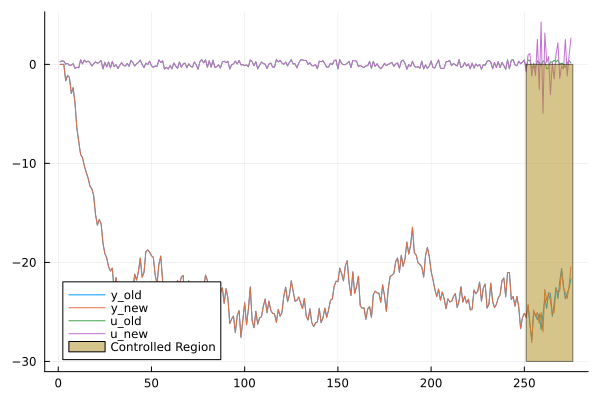

In [22]:
# gs = JuMP.value.(g)
gs = value.(nm[:g])

println("Quadratic error: $((Yf*gs)'*Q*(Yf*gs) + (Uf*gs)'*R*(Uf*gs) )")
t_f=ts+1:ts+N
y_f = deepcopy(y)
e_f = deepcopy(e)
u_f = deepcopy(u)

# Replace random initial inputs with the optimized ones 
u_f[t_f] = Uf*gs

for i in t_f
    y_f[i] = i>max_n ? dot(y_f[(i-na):(i-1)],A_coeffs) + dot(e_f[(i-nc+1):i],C_coeffs) + dot(u_f[(i-nb+1):i],B_coeffs) : 0
end

plot(t[1:ts+N],y[1:ts+N],lab="y_old")
plot!(t[1:ts+N],y_f[1:ts+N],lab="y_new")
plot!(t[1:ts+N],u[1:ts+N],lab="u_old")
plot!(t[1:ts+N],u_f[1:ts+N],lab="u_new")

rectangle(w, h, x_og, y_og) = Shape(x_og .+ [0,w,w,0], y_og .+ [0,0,h,h])
plot!(rectangle(N,30,ts+1,-30), opacity=.5,lab="Controlled Region")

### Simulation of ARMAX with DeePC feedback

In this section the ARMAX model will be simulated with a DeePC controller the objective of the controller is to bring y and u as close to 0 as possible.

In [24]:
# ts+1:SimT
SimTime=50
y_benchmark = deepcopy(y)
u_benchmark = deepcopy(u) 

y_s = deepcopy(y)
e_s = deepcopy(e)
u_s = deepcopy(u) 
HLu2=deepcopy(HLu)
HLy2=deepcopy(HLy)
y_ini2=deepcopy(y_ini)
u_ini2=deepcopy(u_ini)


for i=ts+1:ts+SimTime #SimT
    # Extremely simple controller.
    u_benchmark[i]=-y_benchmark[i-1]/B_coeffs[1]  # + sum(C_coeffs)*5/B_coeffs[1]
    y_benchmark[i] = i>max_n ? dot(y_benchmark[(i-na):(i-1)],A_coeffs) + dot(e_s[(i-nc+1):i],C_coeffs) + dot(u_benchmark[(i-nb+1):i],B_coeffs) : 0
    
    
    # DeePC controller with regularization
    # model = DeePC.SolveDeePC(HLu2[1:T_ini*m,:],HLu2[T_ini*m+1:end,:],HLy2[1:T_ini*p,:],HLy2[T_ini*p+1:end,:],Q,R,y_ini2,u_ini2)

    # DeePC controller with regularization
    model = DeePC.SolveDeePC(HLu2[1:T_ini*m,:],HLu2[T_ini*m+1:end,:],HLy2[1:T_ini*p,:],HLy2[T_ini*p+1:end,:],Q,R,y_ini2,u_ini2,lambda_y,lambda_g)
    
    # Update Hankel Matrices
    
    u_ini2 = circshift(u_ini2,-1);u_ini2[end]=u_s[i]
    y_ini2 = circshift(y_ini2,-1);y_ini2[end]=y_s[i]
    u_s[i]=(HLu2[T_ini*m+1:end,:]*value.(model[:g]))[1]  # (Uf * g) [1]
    y_s[i] = i>max_n ? dot(y_s[(i-na):(i-1)],A_coeffs) + dot(e_s[(i-nc+1):i],C_coeffs) + dot(u_s[(i-nb+1):i],B_coeffs) : 0
    # Update Up, Uf, Yp, Yf
    HLu2=circshift(HLu2,(0,1)); HLu2[:,1]=circshift(HLu2[:,2],-1); HLu2[end,1]=u_s[i]
    HLy2=circshift(HLy2,(0,1)); HLy2[:,1]=circshift(HLy2[:,2],-1); HLy2[end,1]=y_s[i]
    
    println("t: $(i) - y: $(y_s[i]) - u:$(dot(u_s[(i-nb+1):i],B_coeffs))")
end

t: 251 - y: -24.654253430390778 - u:0.6172083522564386
t: 252 - y: -23.624648120181696 - u:0.8502263901585974
t: 253 - y: -25.4756958542326 - u:0.7224929543221817
t: 254 - y: -25.824371080119523 - u:1.1087783204593908
t: 255 - y: -22.78670564687949 - u:1.341830947622625
t: 256 - y: -22.80030880453361 - u:1.100030921175436
t: 257 - y: -22.993979027766223 - u:1.0890220471465708
t: 258 - y: -22.54853232517283 - u:0.649529160698358
t: 259 - y: -23.463783443614137 - u:1.0155175864378114
t: 260 - y: -21.563879850185327 - u:1.3524905775845406
t: 261 - y: -21.161637069386263 - u:-0.04140258842374485
t: 262 - y: -19.820432284817684 - u:1.7552605142889757
t: 263 - y: -18.00442275379143 - u:1.8367484864351113
t: 264 - y: -20.00935675160443 - u:0.16903665416221375
t: 265 - y: -25.524145697663236 - u:-4.061877664523614
t: 266 - y: -24.64067531202041 - u:-3.6629979709974045
t: 267 - y: -24.40622643115033 - u:-3.258760142737478
t: 268 - y: -27.291131317969544 - u:-3.062816381731693
t: 269 - y: -26.21

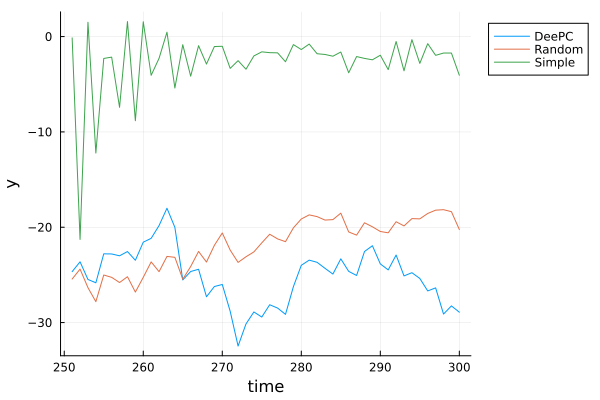

In [27]:
plot(t[ts+1:ts+SimTime],y_s[ts+1:ts+SimTime],lab="DeePC",legend = :outertopright, xlabel = "time", ylabel = "y",)
plot!(t[ts+1:ts+SimTime],y[ts+1:ts+SimTime],lab="Random")
plot!(t[ts+1:ts+SimTime],y_benchmark[ts+1:ts+SimTime],lab="Simple")

# HLu2=deepcopy(HLu)
# Up2= HLu2[1:T_ini*m,:]
# HLu2=circshift(HLu2,(0,1))
# HLu2[:,1]=circshift(HLu2[:,2],-1)
# display(DataFrame(HLu2,:auto))
# DataFrame(Up,:auto)
# print(y_ini)
# print(circshift(y_ini,-1))

# DataFrame(HLy,:auto)
# Up = HLu[1:T_ini*m,:] 
# Yp = HLy[1:T_ini*p,:]
# Uf = HLu[T_ini*m+1:end,:] 
# Yf = HLy[T_ini*p+1:end,:]
